In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from ggplot import *

## Utility functions to parse experiment metadata

In [3]:
def parse_barcodes(bcfile, bc_id='BC'):
    res = {}
    with open(bcfile, 'r') as fi:
        for line in fi:
            fields = line.strip().split(',')
            if fields[0].startswith(bc_id):
                res[fields[0]] = fields[1]
    return res


def parse_exp_config(expfile, bc_dict):
    res = []
    fieldnames = ['id', 'sample', 'cond', 'barcode', 'size', 'region', 'Qbit', 'conc', 'dilution']
    with open(expfile) as fi:
        reader = csv.DictReader(fi, fieldnames=fieldnames)
        for rec in reader:
            if rec['id']:
                res.append({
                    'sample': rec['sample'],
                    'bc_id': rec['barcode'],
                    'bc_seq': bc_dict[rec['barcode']],
                    'temp': int(rec['cond'][:2]),
                    'bcm': '+' in rec['cond'],
                })
    return pd.DataFrame.from_records(res)

## Read the counts table

This is bacterial mRNA-Seq with samples at 4 different temperatures with or without the addition of BCM. Each condition is sequenced in triplicates. And we are interested in `5'UTRs` transcription levels.

In [4]:
bc_dict = parse_barcodes('../data/Lexogen_Sense_RNA-Seq.csv')
exp_df = parse_exp_config('../data/2017-03-09_NextSeq.csv', bc_dict)
agg_utr = pd.DataFrame.from_csv('../data/utr.counts.csv')
agg_utr

,gene,TSS,end,start,UTR_length,utr_counts,sample
0,C0343,2818676,2818728,2818676,52,4,utRho01
1,aaeB,6776526,6776526,6776376,150,20,utRho01
2,aaeR,6778762,6779040,6778762,278,136,utRho01
3,aaeX,6778860,6778860,6778674,186,170,utRho01
4,aat,1854920,1854920,1854864,56,32,utRho01
5,accA,416822,417242,416822,420,2390,utRho01
6,accB,6810280,6810872,6810280,592,13076,utRho01
7,accD,4868030,4868030,4867852,178,740,utRho01
8,aceB,8430804,8430956,8430804,152,102,utRho01
9,aceE,245938,246034,245938,96,764,utRho01


## Normalize to `UTR` length

In [5]:
def normalize(df, edf, columns=None):
    '''
    Prepares the UTR dataframe (`df`) for log transformation.
    
    Adds experiment metadata from `edf`.
    Adds pseudocounts to `utr_counts` and `UTR_length`.
    Normalizes counts to UTR length.
    '''
    def pseudo_counts(x):
        return x + 1 if x == 0 else x

    df = df.merge(edf, how='left', on='sample')
    if columns is not None:
        df = df[columns]
    # Add pseudocounts to allow log transform later
    df['utr_counts'] = df['utr_counts'].apply(pseudo_counts)
    df['UTR_length'] = df['UTR_length'].apply(pseudo_counts)
    df['utr_norm'] = df['utr_counts'] / df['UTR_length']
    return df

In [6]:
columns = ['gene', 'TSS', 'start', 'end', 'UTR_length',
               'utr_counts', 'sample', 'bcm', 'temp']
utr = normalize(agg_utr, exp_df, columns)
utr

,gene,TSS,start,end,UTR_length,utr_counts,sample,bcm,temp,utr_norm
0,C0343,2818676,2818676,2818728,52,4,utRho01,False,10,0.076923
1,aaeB,6776526,6776376,6776526,150,20,utRho01,False,10,0.133333
2,aaeR,6778762,6778762,6779040,278,136,utRho01,False,10,0.489209
3,aaeX,6778860,6778674,6778860,186,170,utRho01,False,10,0.913978
4,aat,1854920,1854864,1854920,56,32,utRho01,False,10,0.571429
5,accA,416822,416822,417242,420,2390,utRho01,False,10,5.690476
6,accB,6810280,6810280,6810872,592,13076,utRho01,False,10,22.087838
7,accD,4868030,4867852,4868030,178,740,utRho01,False,10,4.157303
8,aceB,8430804,8430804,8430956,152,102,utRho01,False,10,0.671053
9,aceE,245938,245938,246034,96,764,utRho01,False,10,7.958333


## `-BCM` samples

In [7]:
# build expression matrix
X = pd.DataFrame()
samples = []

for sample in set(utr['sample']):
    mask = (utr['sample']==sample) & (utr['bcm']==False)
    if not utr[mask].empty:
        X[sample] = utr[mask]['utr_norm'].values
        samples.append(sample)
    
X_std = StandardScaler().fit_transform(X.values.T)
X_std

array([[-0.41182215, -0.35767468,  0.36480451, ..., -0.67030221,
        -0.43604798, -0.7975759 ],
       [-0.41182215, -0.35767468, -1.26864851, ...,  0.03550018,
        -0.85532488, -0.08304569],
       [ 3.38858011, -0.35767468, -1.39115748, ...,  3.18640372,
        -0.34075777,  1.20690265],
       ..., 
       [-0.41182215, -0.35767468, -0.57443098, ...,  0.1426309 ,
        -0.06251037,  3.15447171],
       [-0.41182215, -0.35767468,  0.89567674, ..., -0.35521186,
         1.25630607, -0.56361468],
       [ 1.18622686, -0.35767468,  0.77316776, ..., -0.02121608,
         0.19667898,  0.59986813]])

In [8]:
sklearn_pca = sklearnPCA(n_components=10)
Y = sklearn_pca.fit_transform(X_std)
print(Y)
print(sklearn_pca.explained_variance_)
print(sklearn_pca.explained_variance_ratio_)

[[ -6.30080559e+00   3.73924036e+00  -1.85311316e+01   8.79861815e+00
   -2.30236523e+00   5.50160579e+00  -9.13970912e+00   1.75330517e+00
   -7.95371836e-01  -1.49936590e+00]
 [  9.29415499e-01  -6.18164499e+00  -1.72009951e+01   3.90190886e+00
   -5.49493463e-01   7.52610254e-01  -1.34938215e+00  -2.20760005e+00
    1.01838153e-01   1.09447231e+01]
 [ -1.75999761e+01  -3.26667898e+01   2.62626684e+01  -3.34977237e+00
   -7.20226639e+00  -2.31513457e+01  -2.25837793e+01   4.44320645e+00
   -3.02761258e-01  -1.86420082e-02]
 [ -1.14384673e+01  -9.40841117e+00  -1.90377592e+01  -1.18198791e+01
    3.46392884e+00  -1.92667035e+00   3.75850722e+00  -2.00741120e+00
   -1.25170924e+00   2.48891244e+01]
 [ -8.53029322e+00   6.16438977e+00  -1.87802275e+01   6.37857148e+00
   -2.25020072e+00   5.74290050e+00  -1.07597623e+01   6.26823183e-01
   -1.89630839e+00  -6.92440994e+00]
 [ -9.78874751e+00  -2.54150007e+01   1.56823598e+01   6.96971149e+00
   -3.27985907e+00   1.34188260e+01   7.40965

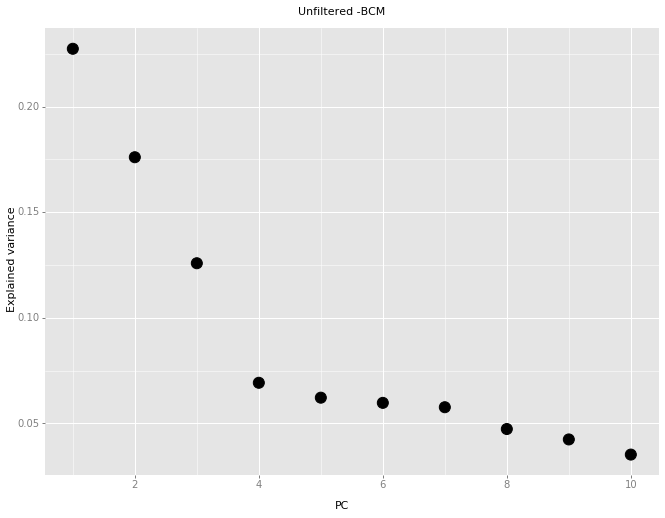

<ggplot: (-9223363304580426608)>


In [9]:
vdf = pd.DataFrame()
vdf['PC'] = [(i+1) for i,x in enumerate(sklearn_pca.explained_variance_ratio_)]
vdf['var'] = sklearn_pca.explained_variance_ratio_

g = ggplot(vdf, aes(x='PC', y='var')) \
    + geom_point(size=10) \
    + ylab('Explained variance') \
    + ggtitle('Unfiltered -BCM')
print(g)

In [11]:
pca_df = pd.DataFrame()
pca_df['cond'] = ['%doC' % exp_df[exp_df['sample']==sample]['temp'] for sample in samples]
pca_df['PC1'] = Y[:,0]
pca_df['PC2'] = Y[:,1]

pca_df

,cond,PC1,PC2
0,25oC,-6.300806,3.739240
1,37oC,0.929415,-6.181645
2,44oC,-17.599976,-32.666790
3,37oC,-11.438467,-9.408411
4,25oC,-8.530293,6.164390
5,44oC,-9.788748,-25.415001
6,10oC,-8.852871,26.686097
7,51oC,35.425659,-0.456606
8,51oC,52.524099,0.768853
9,25oC,-7.998667,4.658008


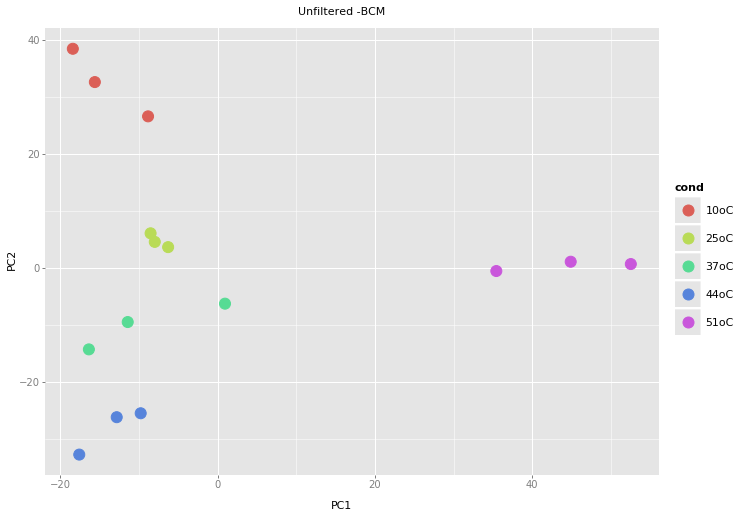

<ggplot: (-9223363304582241462)>


In [12]:
g = ggplot(pca_df, aes(x='PC1', y='PC2', color='cond')) \
    + geom_point(size=10) \
    + ggtitle('Unfiltered -BCM')
print(g)

## `+BCM` samples

In [13]:
# build expression matrix

X = pd.DataFrame()
samples = []

for sample in set(utr['sample']):
    mask = (utr['sample']==sample) & (utr['bcm']==True)
    if not utr[mask].empty:
        X[sample] = utr[mask]['utr_norm'].values
        samples.append(sample)
    
X_std = StandardScaler().fit_transform(X.values.T)
X_std

array([[-0.52008826, -1.01091213, -1.23792619, ..., -0.93258482,
         0.76962785,  0.0732628 ],
       [-0.52008826, -1.01091213, -0.61442217, ...,  1.67582378,
        -0.78130151, -0.85661123],
       [ 1.96215118,  1.31653673, -0.00663674, ..., -0.24348713,
        -0.09026242,  3.37008893],
       ..., 
       [-0.52008826,  1.17547922,  1.15653883, ...,  0.62746817,
        -0.34979294,  0.22119731],
       [-0.52008826, -1.01091213, -1.1855309 , ..., -1.01014174,
         1.45128631, -0.41280772],
       [ 2.43495869,  0.63140027,  2.03154027, ...,  0.38944866,
        -0.44359915, -0.0535382 ]])

In [14]:
sklearn_pca = sklearnPCA(n_components=10)
Y = sklearn_pca.fit_transform(X_std)

print(Y)
print(sklearn_pca.explained_variance_)
print(sklearn_pca.explained_variance_ratio_)

[[ -3.37130881e+01   1.45851207e+00  -1.50862874e+01   7.44624740e+00
   -4.59009537e+00   3.41488872e+00  -1.13385653e+00   2.40747633e-01
   -1.22180934e+00   2.05261769e+00]
 [ -2.12086124e+01  -1.98830920e+01   3.75730772e+00  -2.13009791e+01
    1.18471279e+00  -4.29298238e+00   1.59630324e+00   1.41539866e+00
    7.34173664e+00  -2.32817727e+01]
 [ -1.49913955e+00  -1.14836795e+01   2.25292058e+01   1.89403268e+01
   -7.10782450e+00  -2.68500257e+01   3.60198207e+00  -9.36635082e+00
   -1.97976650e+00   2.66883480e+00]
 [  3.96839817e+01  -6.48702588e+00  -1.33659410e+01   2.54137225e+00
    8.57790929e+00  -1.31991483e+00  -1.00540944e+00   1.14373662e+00
   -2.65532381e+01  -9.11077593e+00]
 [  7.12197320e+00  -1.53701758e+01   2.50897415e+01   1.24911798e+01
   -1.03378225e+01   1.22931627e+01   2.09553576e+00   2.46703191e+01
   -9.55383614e-01  -3.65992534e-01]
 [ -2.47509806e+01  -9.52081998e+00   6.06360934e-01  -9.91147698e+00
    8.49525176e+00  -4.19711051e+00  -9.18443

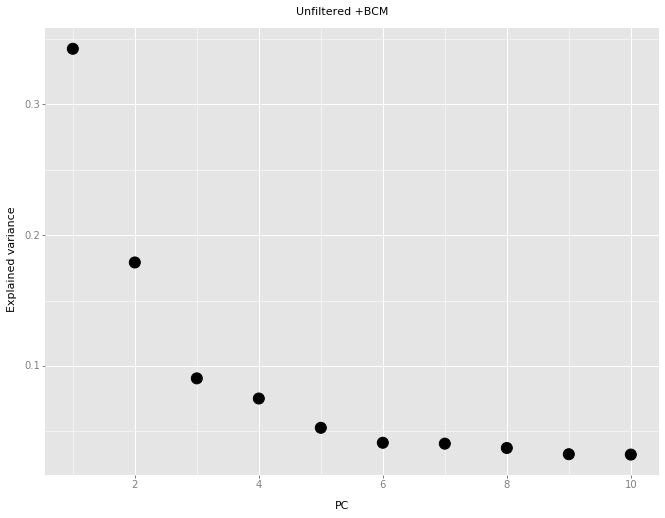

<ggplot: (8732266129072)>


In [15]:
vdf = pd.DataFrame()
vdf['PC'] = [(i+1) for i,x in enumerate(sklearn_pca.explained_variance_ratio_)]
vdf['var'] = sklearn_pca.explained_variance_ratio_

g = ggplot(vdf, aes(x='PC', y='var')) \
    + geom_point(size=10) \
    + ylab('Explained variance') \
    + ggtitle('Unfiltered +BCM')
print(g)

In [16]:
pca_df = pd.DataFrame()
pca_df['cond'] = ['%doC' % exp_df[exp_df['sample']==sample]['temp'] for sample in samples]
pca_df['PC1'] = Y[:,0]
pca_df['PC2'] = Y[:,1]

pca_df

,cond,PC1,PC2
0,10oC,-33.713088,1.458512
1,25oC,-21.208612,-19.883092
2,37oC,-1.499140,-11.483680
3,44oC,39.683982,-6.487026
4,37oC,7.121973,-15.370176
5,25oC,-24.750981,-9.520820
6,51oC,20.506565,51.878090
7,51oC,-7.378953,31.452481
8,25oC,-8.788570,-19.646267
9,10oC,-35.762587,-4.954937


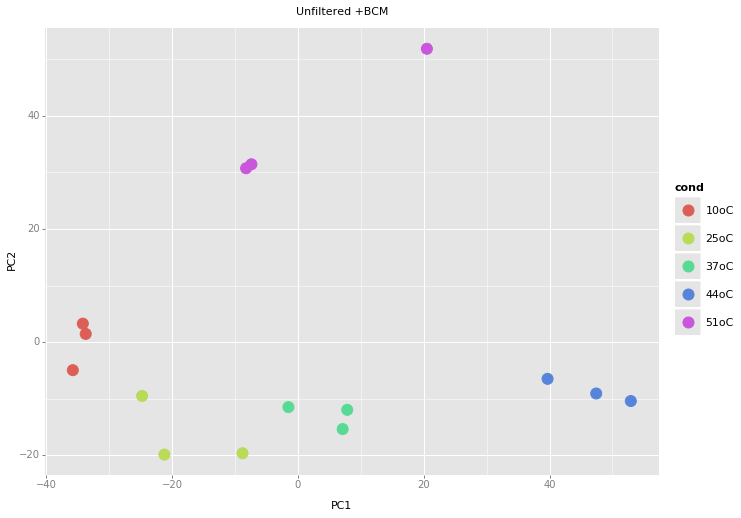

<ggplot: (8732266126256)>


In [17]:
g = ggplot(pca_df, aes(x='PC1', y='PC2', color='cond')) \
    + geom_point(size=10) \
    + ggtitle('Unfiltered +BCM')
print(g)